In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import healpy as hp
from rubin_sim.utils import healbin
import pandas as pd
from rubin_sim.scheduler.utils import empty_observation
from astropy import units
from astropy.coordinates import Angle
from pointing_survey import PointingsSurvey
from rubin_sim.scheduler.schedulers import CoreScheduler
from rubin_sim.scheduler import sim_runner
from rubin_sim.scheduler.model_observatory import ModelObservatory

from rubin_sim.scheduler.surveys import BaseSurvey
from rubin_sim.scheduler.utils import empty_observation

import pickle

In [2]:
tiles = pd.read_csv('/Users/yoachim/git_repos/ts_fbs_utils/python/lsst/ts/fbs/utils/data/auxtel_tiles.txt', delimiter=' ')

In [3]:
tiles

,Survey,Name,RA,Dec
0,LATISS_POLE,001,00:00:00.00,-89:53:48.23
1,LATISS_POLE,002,02:10:54.54,-89:53:48.23
2,LATISS_POLE,003,04:21:49.09,-89:53:48.23
3,LATISS_POLE,004,06:32:43.63,-89:53:48.23
4,LATISS_POLE,005,08:43:38.18,-89:53:48.23
...,...,...,...,...
730,AUXTEL_DRP_IMAGING,HS2027+0651_060,20:29:09.76,+07:18:03.14
731,AUXTEL_DRP_IMAGING,HS2027+0651_061,20:29:32.50,+07:18:03.14
732,AUXTEL_DRP_IMAGING,HS2027+0651_062,20:29:55.24,+07:18:03.14
733,AUXTEL_DRP_IMAGING,HS2027+0651_063,20:30:17.97,+07:18:03.14


In [4]:
obs = empty_observation()
obs = np.zeros(tiles['Survey'].size, dtype=obs.dtype)

In [5]:
obs['note'] = tiles['Survey'] + tiles['Name']
obs['RA'] = Angle(tiles['RA'],unit=units.hourangle).rad
obs['dec'] = Angle(tiles['Dec'],unit=units.degree).rad

obs['flush_by_mjd'] = 0.
obs['nexp'] = 1
obs['filter'] = 'r'
obs['exptime'] = 60.
# obs['rotSkyPos'] = np.nan

In [6]:
obs[0]

(0, 0., -1.56899393, 0., 0., 60., 'r', 0., 0., 1, 0., 0., 0., 0., 0., 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 'LATISS_POLE001', 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0)

In [7]:
# Make a scheduler with one survey object. Dumpign all the pointings in.
# Of course, we could divide them up into different survey objects if that was handy.
ps = PointingsSurvey(obs)
sched = CoreScheduler([ps])

In [8]:
mo = ModelObservatory()

# Let's change the limits on the rotator 
print(np.degrees(mo.observatory.telrot_minpos_rad))
print(np.degrees(mo.observatory.telrot_maxpos_rad))


-90.0
90.0


In [9]:
# Let's change the limits on the rotator 

# XXX--need to work out a better detailer to handle this.
mo.observatory.telrot_minpos_rad = np.radians(-270)
mo.observatory.telrot_maxpos_rad = np.radians(270)


In [10]:
conditions = mo.return_conditions()
ack = ps.generate_observations(conditions)
ack
print(np.degrees(ack[0]['rotSkyPos_desired']))
print(ack[0]['rotTelPos'])

[191.73388]
[0.40958968]


/Users/yoachim/git_repos/22_Scratch/auxTel_test/pointing_survey.py:196: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.+self.n_obs/sum_obs)


In [11]:
mo, sched, completed_obs = sim_runner(mo, sched, survey_length=3)


progress = 99.49%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1627 observations
ran in 0 min = 0.0 hours


/Users/yoachim/git_repos/rubin_sim/rubin_sim/skybrightness_pre/sky_model_pre.py:272: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn(


In [12]:
obs.shape

(735,)

Text(0.5, 1.0, 'input possible pointings')

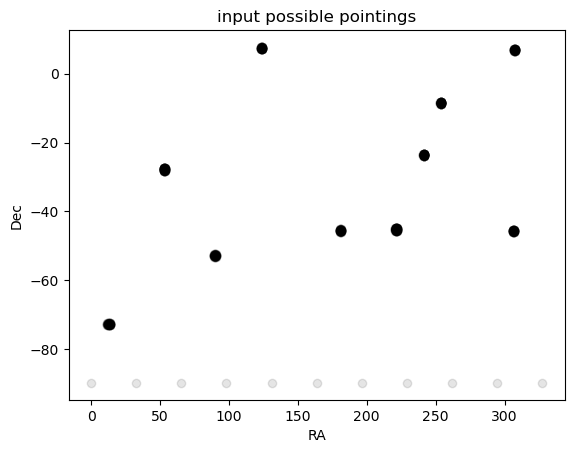

In [28]:
# Here's where the inital list of pointings was
plt.plot(np.degrees(obs['RA']), np.degrees(obs['dec']),  'ko', alpha=.1)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('input possible pointings')

In [14]:
file = open('save_test.pkl', 'wb')
pickle.dump(sched, file)
file.close()

In [15]:
# How large is it to save this thing
from subprocess import Popen
Popen('ls -lh *.pkl', shell=True)

<Popen: returncode: None args: 'ls -lh *.pkl'>

-rw-r--r--  1 yoachim  staff   3.1M May  3 12:08 save_test.pkl


Text(0, 0.5, 'Dec')

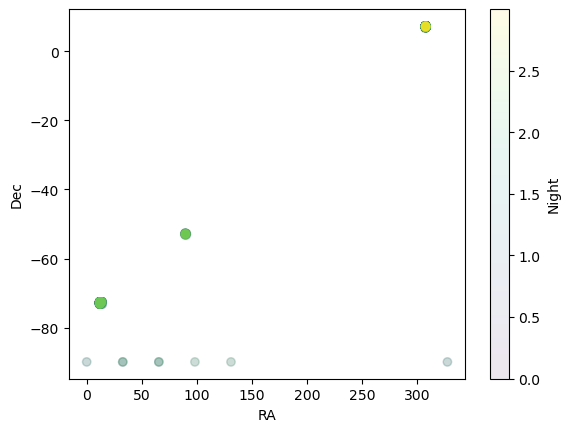

In [16]:
plt.scatter(np.degrees(completed_obs['RA']), np.degrees(completed_obs['dec']),
            c=completed_obs['mjd']-completed_obs['mjd'].min(), alpha=0.1)
cb = plt.colorbar()
cb.set_label('Night')
plt.xlabel('RA')
plt.ylabel('Dec')

Text(0.5, 1.0, 'night 1 path')

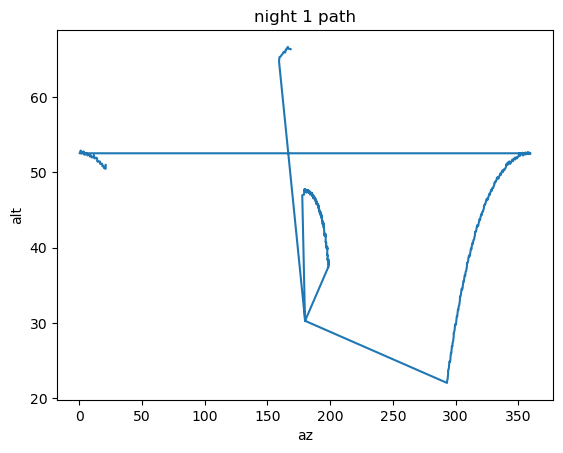

In [27]:
good=np.where(completed_obs['night'] == 1)
plt.plot(np.degrees(completed_obs['az'][good]), np.degrees(completed_obs['alt'][good]))
plt.xlabel('az')
plt.ylabel('alt')
plt.title('night 1 path')

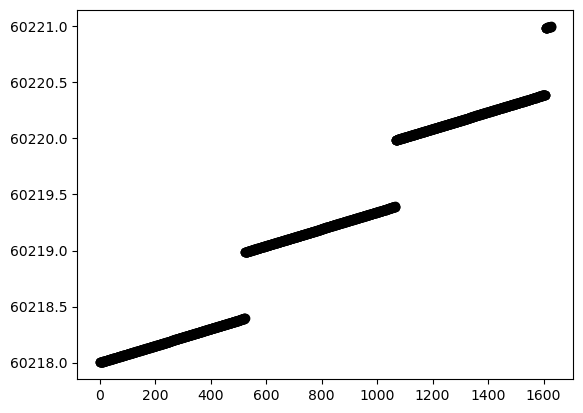

In [17]:
plt.plot(completed_obs['mjd'], 'ko')

In [18]:
# are we keeping rotSkyPos at that paralactic angle?
np.degrees(completed_obs["rotSkyPos"])

array([191.73388   , 191.82611463, 191.48211601, ..., 189.5447166 ,
       189.03960565, 188.23445528])

In [19]:
np.degrees(completed_obs["pa"])

array([191.73388   , 191.82611463, 191.48211601, ..., 189.5447166 ,
       189.03960565, 188.23445528])

In [20]:
np.degrees(completed_obs["rotTelPos"])

array([23.46776   , 23.65222926, 22.96423202, ..., 19.0894332 ,
       18.07921131, 16.46891055])

In [21]:
np.degrees(completed_obs["rotTelPos"]).max()

269.9762144795748

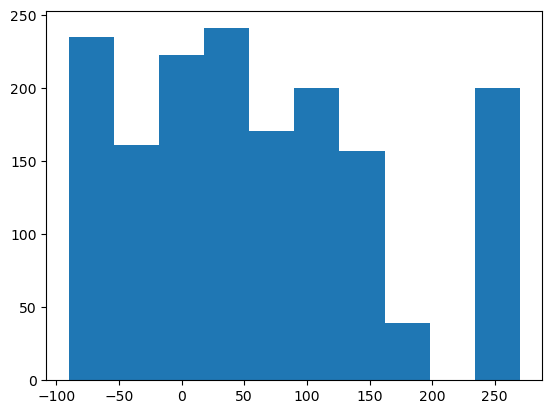

In [22]:
ack = plt.hist(np.degrees(completed_obs["rotTelPos"]))